In [1]:
import transformers
import torch
import numpy as np
import random
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm  import tqdm

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from utils import get_dir_of_obj

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 8, 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

def lock_seed(seed = 666):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 666

lock_seed(SEED)


f:\Library\Og\Python\Machine_Learning\Portfolio\Cover_Letter_Generator\venv\venv_win\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json('resume_dataset/text_classif_en.json', orient='index')
df.head()

,text,class
0,Milicent Schaghticoke,name
1,milicentschaghticoke4@gmail.com,email
2,"Vazquez, Allen and Carter, ['Foreign moment di...",random_info
3,Psychiatric Technician. consisted of the syste...,workexperience
4,Train Crew. Nagios Event handlers in case of f...,workexperience


In [3]:
# Shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,text,class
0,"Farm Labor Contractor. will generate daily, mo...",workexperience
1,"Health Services Manager. Ruby, MVC, MySQL, Cuc...",workexperience
2,Grinding Machine Operator. management procedur...,workexperience
3,celiebrockton5@gmail.com,email
4,Equipment Worker. avenues to bring the EMC dis...,workexperience


In [4]:
num_classes = df['class'].nunique()

(array([6000.,    0., 1200.,    0., 1200.,    0., 1200.,    0., 1200.,
        1200.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

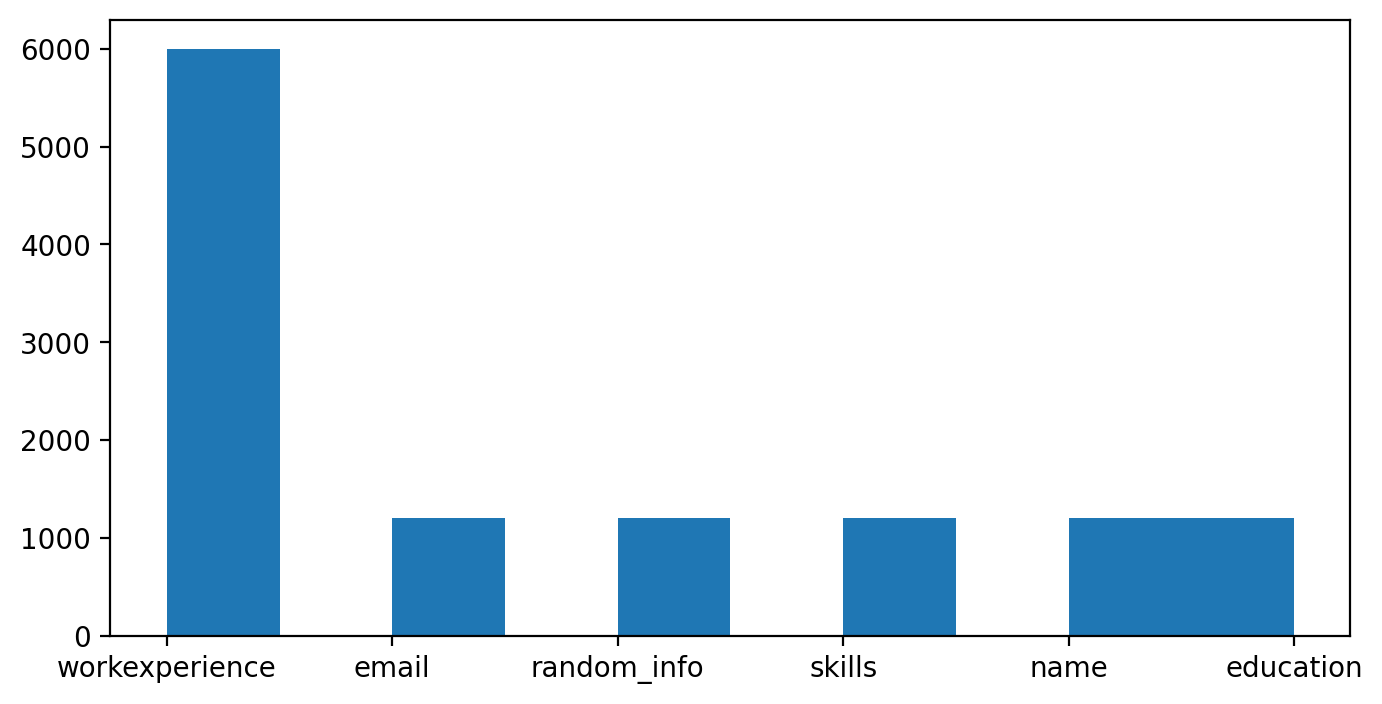

In [5]:
plt.hist(df['class'])

In [6]:
work_df = df[df['class'] == 'workexperience']
non_work_df = df[df['class'] != 'workexperience']
print(work_df['class'].nunique(), work_df.shape)
print(non_work_df['class'].nunique(), non_work_df.shape)

1 (6000, 2)
5 (6000, 2)


Remove extra workexperience rows

6 (7200, 2)


(array([1200.,    0., 1200.,    0., 1200.,    0., 1200.,    0., 1200.,
        1200.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

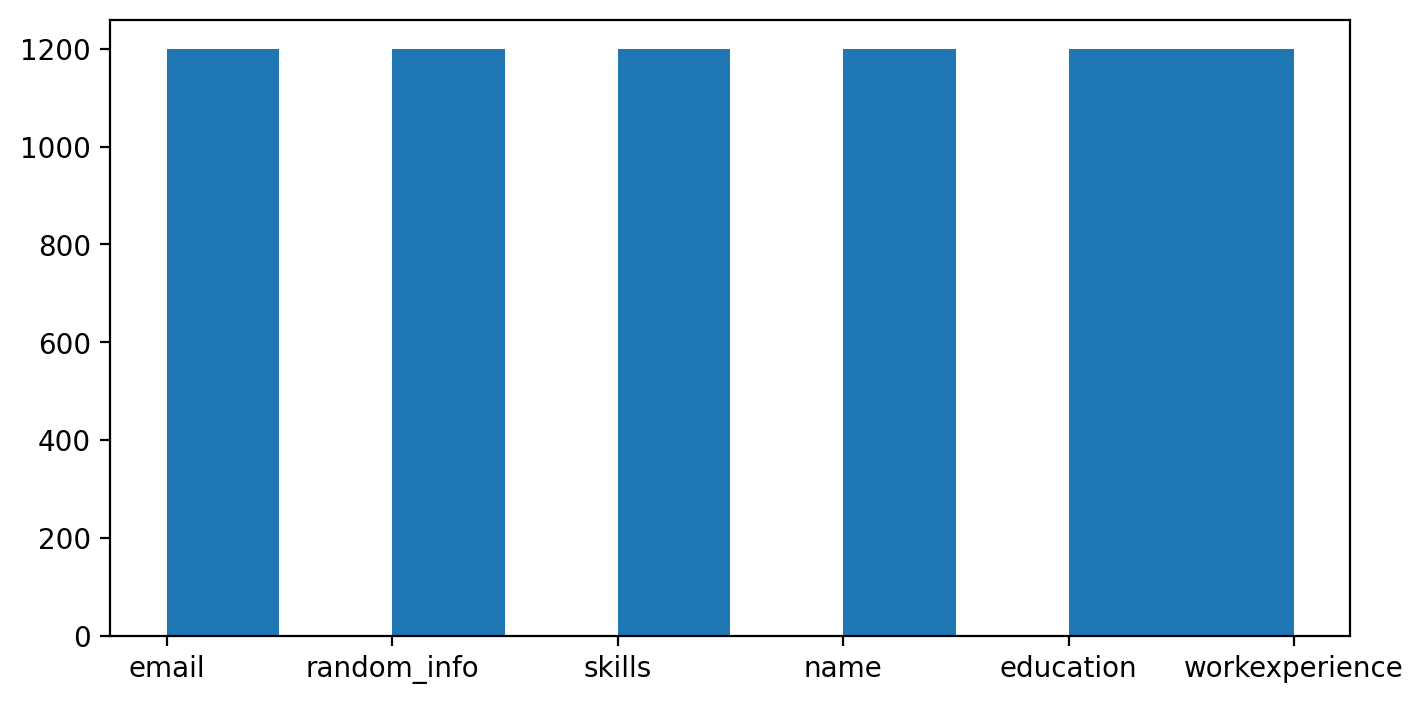

In [7]:
df = df.drop(work_df.index[:int(len(work_df.index) * 0.8)])
df = df.reset_index().drop('index', axis=1)  # Reset indeces
print(df['class'].nunique(), df.shape)
plt.hist(df['class'])

Convert categorical to numeric for 'class'

In [33]:
le = LabelEncoder()
class2int_array = le.fit_transform(df['class'])
df['class_no'] = class2int_array

# Get encoder map of classes
encoded_cls = {}
for cl in le.classes_:
    encoded_cls.update({le.transform([cl])[0]:cl})

print(encoded_cls)
df.head()

{0: 'education', 1: 'email', 2: 'name', 3: 'random_info', 4: 'skills', 5: 'workexperience'}


,text,class,class_no
0,Milicent Schaghticoke,name,2
1,milicentschaghticoke4@gmail.com,email,1
2,"Vazquez, Allen and Carter, ['Foreign moment di...",random_info,3
3,Psychiatric Technician. consisted of the syste...,workexperience,5
4,Train Crew. Nagios Event handlers in case of f...,workexperience,5


Spliting dataset to train, val, test

In [9]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=SEED)

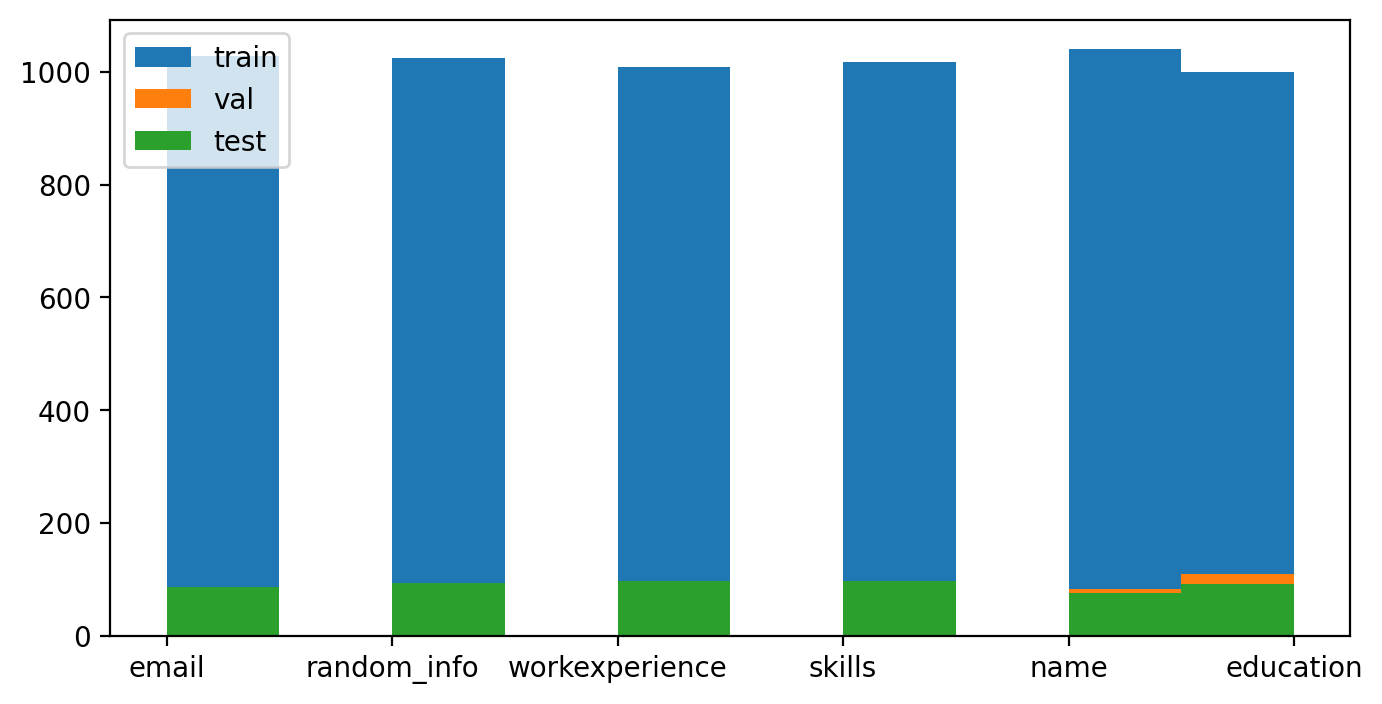

In [10]:
df_train.shape, df_val.shape, df_test.shape
plt.hist(df_train['class'], label='train')
plt.hist(df_val['class'], label='val')
plt.hist(df_test['class'], label='test')
plt.legend()

Choose length of tokenizer sequence

In [11]:
pretrained_model_name = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(pretrained_model_name)

In [12]:
token_len = []

# for txt in df['text']:
#     tokens = tokenizer.encode(txt, max_length=512)
#     token_len.append(len(tokens))
# sns.displot(token_len)

Create dataset

In [13]:
class ResumeTextDataset(Dataset):
    
    def __init__(self, text_sequences, targets, tokenizer, max_len):
        self.text_sequences = text_sequences
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text_sequences)
    
    def __getitem__(self, index):
        text = str(self.text_sequences[index])
        target = self.targets[index]

        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            add_special_tokens=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        return {
        'review_text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
    }

In [14]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    data_set = ResumeTextDataset(
        text_sequences=df['text'].to_numpy(),
        targets=df['class_no'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        data_set,
        batch_size=batch_size
    )

Parameters

In [15]:
MAX_LEN = 512
BATCH_SIZE = 4
EPOCHS = 10

In [16]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Checking Sample Batch

In [17]:
sample_batch = next(iter(train_data_loader))
sample_batch.keys()
print(sample_batch['input_ids'].shape)
print(sample_batch['attention_mask'].shape)
print(sample_batch['targets'].shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([4])


f:\Library\Og\Python\Machine_Learning\Portfolio\Cover_Letter_Generator\venv\venv_win\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


THE MODEL ITSELF

In [18]:
class ResumeTextClassifier(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained(pretrained_model_name)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sm = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(bert_out.pooler_output)
        return self.out(output)
    
    def inference(self, input_ids, attention_mask):
        output = self.forward(input_ids, attention_mask)
        return self.sm(output)

In [19]:
model = ResumeTextClassifier(num_classes)
model = model.to(device)

Checking model output on Sample Batch

In [20]:
sb_input_ids = sample_batch['input_ids'].to(device)
sb_attention_mask = sample_batch['attention_mask'].to(device)
model.inference(sb_input_ids, sb_attention_mask)

tensor([[0.1847, 0.1626, 0.3156, 0.1277, 0.1147, 0.0947],
        [0.0960, 0.1552, 0.4130, 0.1501, 0.0901, 0.0956],
        [0.1331, 0.1539, 0.3545, 0.0922, 0.0817, 0.1846],
        [0.1350, 0.1790, 0.2720, 0.0956, 0.1329, 0.1855]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

Training

In [21]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
    )

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
def train_model(
	model,
	data_loader,
	loss_fn,
	optimizer,
	device,
	scheduler,
	n_examples
):
	
	model = model.train()
	losses = []
	correct_predictions = 0

	for d in data_loader:
		input_ids = d["input_ids"].to(device)
		attention_mask = d["attention_mask"].to(device)
		targets = d["targets"].to(device)

		outputs = model(
			input_ids=input_ids,
			attention_mask=attention_mask
		)
		preds = outputs.argmax(dim=1)
		
		loss = loss_fn(outputs, targets)
		correct_predictions += torch.sum(preds == targets)
		losses.append(loss.item())
		
		loss.backward()
		nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
		optimizer.step()
		scheduler.step()
		optimizer.zero_grad()
		
	return (preds == targets).float().mean(), np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
	
	model = model.eval()
	losses = []
	correct_predictions = 0
	
	with torch.no_grad():
		for d in data_loader:
			input_ids = d["input_ids"].to(device)
			attention_mask = d["attention_mask"].to(device)
			targets = d["targets"].to(device)

			outputs = model(
				input_ids=input_ids,
				attention_mask=attention_mask
			)
			preds = outputs.argmax(dim=1)
			
			loss = loss_fn(outputs, targets)
			correct_predictions += torch.sum(preds == targets)
			losses.append(loss.item())

	return (preds == targets).float().mean(), np.mean(losses)

Testing on small dataset (1000)

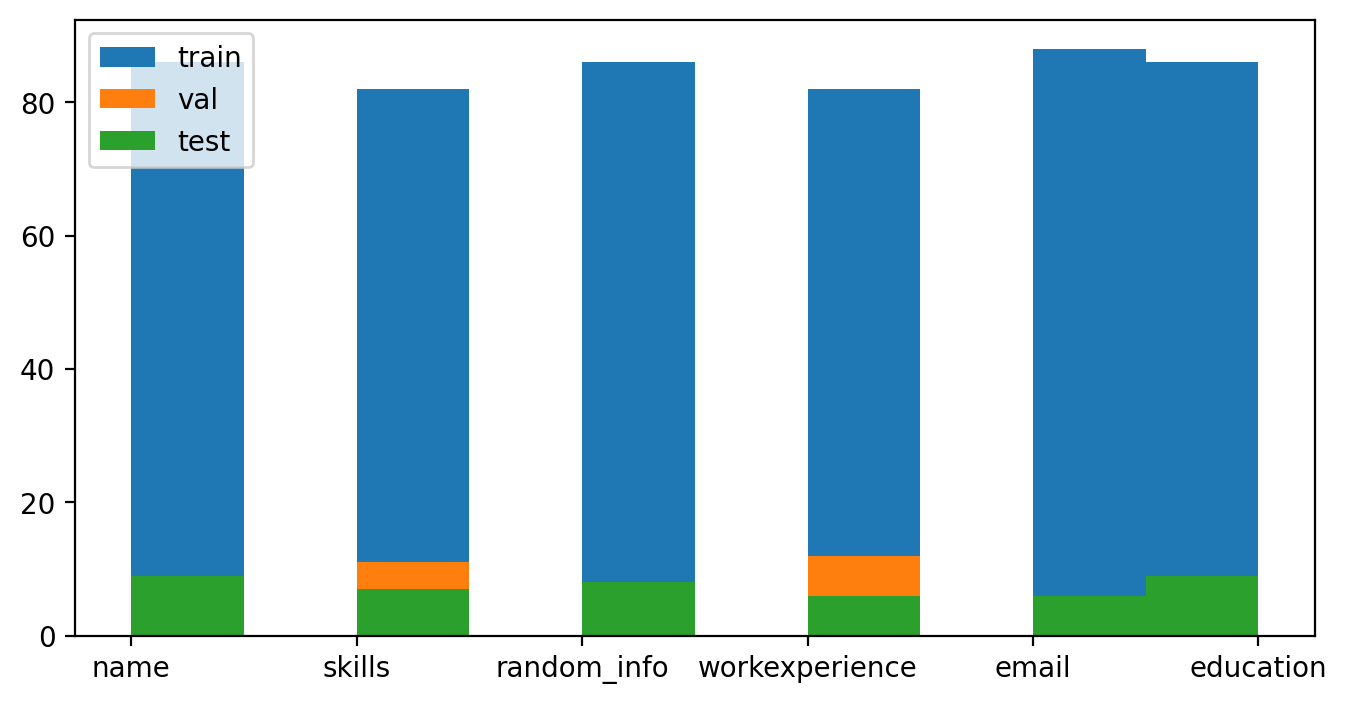

In [24]:
df = pd.read_json('resume_dataset/text_classif_en.json', orient='index')
test_df = df.iloc[0:1000]

work_df = test_df[test_df['class'] == 'workexperience']
test_df = test_df.drop(work_df.index[:int(len(work_df.index) * 0.8)])
test_df = test_df.reset_index().drop('index', axis=1)  # Reset indeces

le = LabelEncoder()
class2int_array = le.fit_transform(test_df['class'])
test_df['class_no'] = class2int_array

df_train, df_test = train_test_split(test_df, test_size=0.15, random_state=SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=SEED)

plt.hist(df_train['class'], label='train')
plt.hist(df_val['class'], label='val')
plt.hist(df_test['class'], label='test')
plt.legend()

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [25]:
history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):

    train_accuaracy, train_loss = train_model(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_accuaracy}')

    val_accuaracy, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Validation loss {val_loss} accuracy {val_accuaracy}')
    print()

    history['train_accuaracy'].append(train_accuaracy.cpu())
    history['train_loss'].append(train_loss)
    history['val_accuaracy'].append(val_accuaracy.cpu())
    history['val_loss'].append(val_loss)

    # if val_accuaracy > best_accuracy:
    #     torch.save(model.state_dict(), 'best_model_state.bin')
    #     best_accuracy = val_accuaracy

  0%|          | 0/10 [00:00<?, ?it/s]f:\Library\Og\Python\Machine_Learning\Portfolio\Cover_Letter_Generator\venv\venv_win\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 0.6479979517753236 accuracy 1.0


 10%|█         | 1/10 [00:38<05:47, 38.58s/it]

Validation loss 0.050763875246047974 accuracy 1.0

Train loss 0.017128711060649948 accuracy 1.0


 20%|██        | 2/10 [01:19<05:17, 39.68s/it]

Validation loss 0.006499423800657193 accuracy 1.0

Train loss 0.00444469188551011 accuracy 1.0


 30%|███       | 3/10 [02:00<04:43, 40.57s/it]

Validation loss 0.0033451790999000273 accuracy 1.0

Train loss 0.0026273701341779088 accuracy 1.0


 40%|████      | 4/10 [02:41<04:04, 40.74s/it]

Validation loss 0.0022974960544767478 accuracy 1.0

Train loss 0.0017547984216434998 accuracy 1.0


 50%|█████     | 5/10 [03:25<03:29, 41.82s/it]

Validation loss 0.0016925826688141872 accuracy 1.0

Train loss 0.0013072862207081926 accuracy 1.0


 60%|██████    | 6/10 [04:09<02:50, 42.69s/it]

Validation loss 0.0012632140327089776 accuracy 1.0

Train loss 0.0009847367578004196 accuracy 1.0


 70%|███████   | 7/10 [04:54<02:09, 43.23s/it]

Validation loss 0.0010205208333597209 accuracy 1.0

Train loss 0.0007985390670910419 accuracy 1.0


 80%|████████  | 8/10 [05:38<01:27, 43.56s/it]

Validation loss 0.0008093642560803952 accuracy 1.0

Train loss 0.0006426206350624852 accuracy 1.0


 90%|█████████ | 9/10 [06:21<00:43, 43.36s/it]

Validation loss 0.0007231463944966284 accuracy 1.0

Train loss 0.0005613158298274357 accuracy 1.0


100%|██████████| 10/10 [07:04<00:00, 42.42s/it]

Validation loss 0.0005789996042343167 accuracy 1.0



(0.0, 1.0)

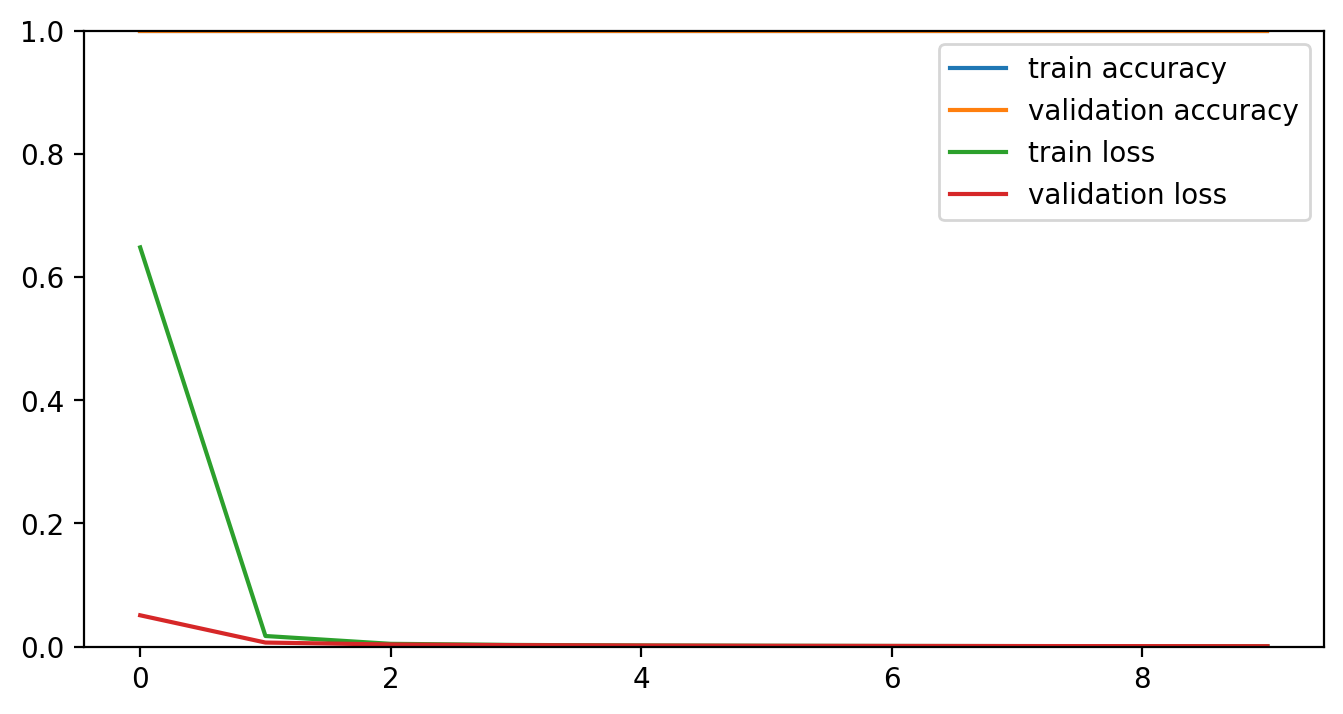

In [26]:
plt.plot(history['train_accuaracy'], label='train accuracy')
plt.plot(history['val_accuaracy'], label='validation accuracy')
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.legend()
plt.ylim([0, 1])

In [27]:
test_accuaracy, test_loss = eval_model(
        model,
        test_data_loader,
        loss_fn,
        device,
        len(df_test)
    )
test_accuaracy.item(), test_loss

f:\Library\Og\Python\Machine_Learning\Portfolio\Cover_Letter_Generator\venv\venv_win\Lib\site-packages\transformers\tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(tensor(1., device='cuda:0'), 0.0003377660929497021)

Predicting on Raw Text

In [57]:
raw_text = ""

encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)

input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
pred = output.argmax(dim=1)


print(f'Raw text: {raw_text}')
print(f'Class  : {encoded_cls[pred.item()]}')


Raw text: Bookkeeping (1 years) Bookkeeping (1 years) Bookkeeping (1 years) Bookkeeping (1 years)
Class  : skills
